# ELAPID MAXENT Example with Measurer

## Setup the Measurer

In [1]:
# silent install of required additional packages for the user
!pip install loguru codecarbon --quiet --user

In [2]:
# get logger, and initialise a measurer tracker
import sys
from loguru import logger
from measurer.measurer import Measurer
from types import ModuleType

#logger.remove(0)
logger.add(sys.stdout, level='INFO')

1

## Setup the Model

In [3]:
# essential packages
import numpy as np
import pandas as pd
import geopandas as gpd
import elapid

In [4]:
# files to process
presence_data_filename   = "../../s3/uc2-data/veldleeuwerik_arable.csv"
background_data_filename = "../../s3/uc2-data/veldleeuwerik_background_arable.csv"

## Data Preparation

In [5]:
# Load the datasets
background_data = pd.read_csv(background_data_filename)
presence_data = pd.read_csv(presence_data_filename)

background_data = background_data.dropna()
presenence_data = presence_data.dropna()

# Rename columns for consistency
background_data = background_data.rename(columns={'x': 'longitude', 'y': 'latitude'})
background_data = background_data.drop(columns=['Unnamed: 0'])

presence_data = presence_data.rename(columns={'x': 'longitude', 'y': 'latitude'})
presence_data = presence_data.drop(columns=['Unnamed: 0', 'abundance_'])

# Combine presence and background data
presence_labels = np.ones(len(presence_data))  # 1 for presence
background_labels = np.zeros(len(background_data))  # 0 for background

# Combine the data into one dataset
combined_data = pd.concat([presence_data, background_data], ignore_index=True)
labels = np.concatenate([presence_labels, background_labels])

# Select environmental variables (excluding species and coordinates)
features = combined_data.drop(columns=['longitude', 'latitude'])
features_presences = presence_data.drop(columns=['longitude', 'latitude'])

## Model Training

In [6]:
measurer_train = Measurer()
tracker_train = measurer_train.start(logger=logger)

2025-03-11 15:10:04.795 | INFO     | measurer.measurer:start:282 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


2025-03-11 15:10:04.795 | INFO     | measurer.measurer:start:282 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


In [7]:
model = elapid.MaxentModel()
model.fit(features, labels, categorical=[1])

MaxentModel()

In [8]:
measurer_train.end(
    tracker=tracker_train,
    shape=[],
    libraries=[k for k,v in globals().items() if type(v) is ModuleType and not k.startswith('__')],
    #program_path=__file__,
    variables=locals(),
    csv_file='benchmarks_elapid_maxent_train_veldleeuwerik_arable_land.csv',
    logger=logger
)

/home/conda/fairicubeuc2/cd9a36edb0dc3ee807d8480c9bf1b860e5adb8ac735017d90955d1b8f50febd7-20241127-193535-689672-40-sdm-torch/lib/python3.10/site-packages/codecarbon/output.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
2025-03-11 15:27:43.407 | INFO     | measurer.measurer:end:311 - Stopped computational costs meter. Results saved at


2025-03-11 15:27:43.407 | INFO     | measurer.measurer:end:311 - Stopped computational costs meter. Results saved at
                                    Measure  \
0                 Data size in grid points    
1   Largest allocated array in grid points    
2                            Data size (MB)   
3                            Data read (MB)   
4                         Data written (MB)   
5                Main memory available (MB)   
6                 Main memory consumed (MB)   
7      Sum of allocated variable sizes (MB)   
8                    Description of CPU/GPU   
9                             Wall time (s)   
10                      Energy consumed (W)   
11              CO₂-equivalents [CO₂eq] (g)   
12                     Network traffic (MB)   
13                     Programming language   
14                      Essential libraries   

                                                Value  
0                                                      
1                 

## Model Inference

In [9]:
measurer_infer = Measurer()
tracker_infer = measurer_infer.start(logger=logger)

2025-03-11 15:27:43.414 | INFO     | measurer.measurer:start:282 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


2025-03-11 15:27:43.414 | INFO     | measurer.measurer:start:282 - Started computational costs meter: wall time, memory consumed, network traffic, CO2 emissions, data size


In [10]:
predicted_probabilities = model.predict(features)
predicted_probabilities_presences = model.predict(features_presences)

In [11]:
measurer_infer.end(
    tracker=tracker_infer,
    shape=[],
    libraries=[k for k,v in globals().items() if type(v) is ModuleType and not k.startswith('__')],
    #program_path=__file__,
    variables=locals(),
    csv_file='benchmarks_elapid_maxent_infer_veldleeuwerik_arable_land.csv',
    logger=logger
)

/home/conda/fairicubeuc2/cd9a36edb0dc3ee807d8480c9bf1b860e5adb8ac735017d90955d1b8f50febd7-20241127-193535-689672-40-sdm-torch/lib/python3.10/site-packages/codecarbon/output.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
2025-03-11 15:27:49.275 | INFO     | measurer.measurer:end:311 - Stopped computational costs meter. Results saved at


2025-03-11 15:27:49.275 | INFO     | measurer.measurer:end:311 - Stopped computational costs meter. Results saved at
                                    Measure  \
0                 Data size in grid points    
1   Largest allocated array in grid points    
2                            Data size (MB)   
3                            Data read (MB)   
4                         Data written (MB)   
5                Main memory available (MB)   
6                 Main memory consumed (MB)   
7      Sum of allocated variable sizes (MB)   
8                    Description of CPU/GPU   
9                             Wall time (s)   
10                      Energy consumed (W)   
11              CO₂-equivalents [CO₂eq] (g)   
12                     Network traffic (MB)   
13                     Programming language   
14                      Essential libraries   

                                                Value  
0                                                      
1                 

## Evaluation

In [12]:
# calculate ROC AUC
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(labels, predicted_probabilities)
print(f"Model AUC: {auc_score}")

Model AUC: 0.7260172589085502


In [13]:
# Calculate omission rate
threshold = 0.5 # Threshold for when predicted probability = presence
omission_rate = sum(predicted_probabilities_presences < threshold) / len(predicted_probabilities_presences)
print(f"Omission Rate: {omission_rate}")

Omission Rate: 0.1410958904109589


## Visualisations

### Plot results on a map

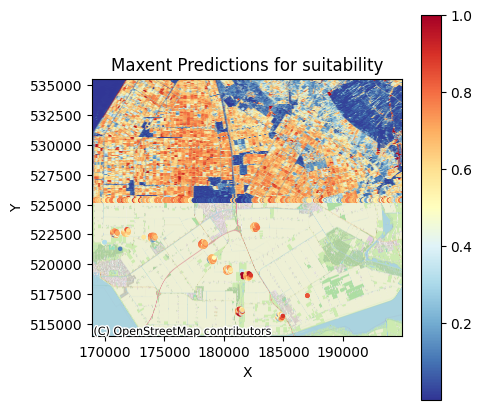

In [14]:
# Plot Predicted probabilities for the test data
import matplotlib.pyplot as plt
import contextily as ctx
import rasterio
from rasterio.transform import from_bounds

test_data_with_coords = combined_data.iloc[features.index][['longitude', 'latitude']]
gdf_test = gpd.GeoDataFrame(test_data_with_coords, geometry=gpd.points_from_xy(test_data_with_coords['longitude'], test_data_with_coords['latitude']), crs='EPSG:28992')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

gdf_test.plot(ax=ax, column=predicted_probabilities, cmap='RdYlBu_r', legend=True, markersize=5)
ax.set_title('Maxent Predictions for suitability')
ax.set_xlabel('X')
ax.set_xlim(168910, 194950) # set limits for study area
ax.set_ylabel('Y')
ax.set_ylim(513945, 535555)

ctx.add_basemap(ax, crs='EPSG:28992', source=ctx.providers.OpenStreetMap.Mapnik, zoom=15)

fig

# Studiegebied limieten en rasterresolutie
xmin, xmax, ymin, ymax = 168910, 194950, 513945, 535555
resolution = 10

# Bereken raster dimensies
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Maak een lege raster-array
raster_array = np.full((height, width), np.nan)

# Raster grid coördinaten
x_coords = np.linspace(xmin + resolution / 2, xmax - resolution / 2, width)
y_coords = np.linspace(ymax - resolution / 2, ymin + resolution / 2, height)  # Omgekeerd voor rasterordening

# Combineer de voorspellingen met coördinaten
data_with_predictions = combined_data.copy()
data_with_predictions['predicted_probabilities'] = predicted_probabilities

# Vul het raster met de voorspellingen
for _, row in data_with_predictions.iterrows():
    col = int((row['longitude'] - xmin) / resolution)
    row_idx = int((ymax - row['latitude']) / resolution)
    if 0 <= col < width and 0 <= row_idx < height:
        raster_array[row_idx, col] = row['predicted_probabilities']

# Opslaan als .tif bestand
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)
with rasterio.open(
    'output_elapid_maxent_veldleeuwerik_arable.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=raster_array.dtype,
    crs='EPSG:28992',
    transform=transform
) as dst:
    dst.write(raster_array, 1)

### Partial dependence plots

In [15]:
# partial dependence plots
from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence
display = PartialDependenceDisplay.from_estimator(model, features, features=[0, 1, 2 , 3, 4, 5],kind='average')

KeyboardInterrupt: 